In [1]:
import pandas as pd
import numpy as np
import os
import time as time
from utils import *
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib import rcParams
import random
from collections import Counter
rcParams['font.family'] = 'Arial'  

In [2]:
def sequence_identity(seq1, seq2):
    sites = 0 # where at least one sequence is not a gap
    identical_sites = 0 
    seq1 = seq1.upper()
    seq2 = seq2.upper()
    if len(seq1) != len(seq2):
        print('Different sequence lengths')
        return
    for i, nt in enumerate(seq1):
        if seq1[i] in '-N' and seq2[i] in '-N':
            continue
        
        sites += 1
        if seq1[i] == seq2[i]:
            identical_sites += 1

    return identical_sites/sites


def sequence_identity_relToRef(ref, seq):
    sites = 0 # where at least one sequence is not a gap
    identical_sites = 0 
    ref = ref.upper()
    seq = seq.upper()
    if len(ref) != len(seq):
        print('Different sequence lengths')
        return
    for i, nt in enumerate(ref):
        if ref[i] in '-N' or seq[i] in '-N':
            continue
        
        sites += 1
        if ref[i] == seq[i]:
            identical_sites += 1

    if sites == 0:
        return 0
    else:
        return identical_sites/sites
    

# read in data
def load_data(metadata_path, fasta_path, recCA_fasta_path, sc):
    metadata_df = pd.read_csv(metadata_path, sep=',', comment='#')
    original_fasta = readFASTA(fasta_path)
    recCA_fasta = readFASTA(recCA_fasta_path)
    if sc == 1:
        sc_key = 'AY394995.1'
    else:
        sc_key = 'MN908947.3'

    # calculate genetic distance between each recCA and given human SARS-CoV
    recCA_over_time_diffs = {key:(sequence_identity_relToRef(original_fasta[sc_key], recCA_fasta[key])) for key in recCA_fasta}

    # calculate genetic distance between each genome and the given human SARS-CoV
    sc_similarity = {}
    for key in original_fasta:
        if key == sc_key:
            continue
        sc_similarity[key] = sequence_identity_relToRef(original_fasta[sc_key], original_fasta[key])
    sc_similarity = {k: v for k, v in sorted(sc_similarity.items(), key=lambda item: item[1])[::-1]}

    # calculate genetic distance between each genome and the given human SARS-CoV by date
    sc_similarity_by_date = {}
    max_similarity = 0
    max_key = None
    for row in metadata_df.sort_values(by='submission_date').iterrows():
        name = row[1]['name']
        if name == sc_key:
            continue
        sub_date = row[1]['submission_date']
        similarity = sc_similarity[name]
        if similarity > max_similarity:
            max_similarity = similarity
        sc_similarity_by_date[sub_date] = max_similarity
        max_key = name
        

    # calculate min genetic distance (max genetic similarity) between most recent recCA and the given human SARS-CoV
    recCA_distance = (len(original_fasta[sc_key].replace('-','').replace('N',''))) - (max(recCA_over_time_diffs.values())*len(original_fasta[sc_key].replace('-','').replace('N','')))
    recCA_similarity = max(recCA_over_time_diffs.values())
    
    return {'recCA_over_time_diffs':recCA_over_time_diffs, 'sc_similarity_by_date':sc_similarity_by_date, 'recCA_distance':recCA_distance, 'recCA_similarity':recCA_similarity}



In [3]:
sc1_metadata_path = '../../../data/metadata.sc1.edited.csv' # metadata specific to sars-cov-1-like viruses
sc2_metadata_path = '../../../data/metadata.sc2.edited.csv' # metadata specific to sars-cov-2-like viruses
recCAs_sc1_fasta_path = '../sars-cov-1-like_viruses/Bayesian_divergence_time_estimation_and_recCA_inference/Primary_analysis/recCA_over_time.fasta'
recCAs_sc2_fasta_path = '../sars-cov-2-like_viruses/Bayesian_divergence_time_estimation_and_recCA_inference/Primary_analysis/recCA_over_time.fasta'
sc1_fasta_path = '../../../data/SC1_complete_hmm.clean.fasta' # fasta specific to sars-cov-1-like viruses
sc2_fasta_path = '../../../data/SC2_complete_hmm.clean.fasta' # fasta specific to sars-cov-2-like viruses
sc1_results = load_data(sc1_metadata_path, sc1_fasta_path, recCAs_sc1_fasta_path, 1)
sc2_results = load_data(sc2_metadata_path, sc2_fasta_path, recCAs_sc2_fasta_path, 2)

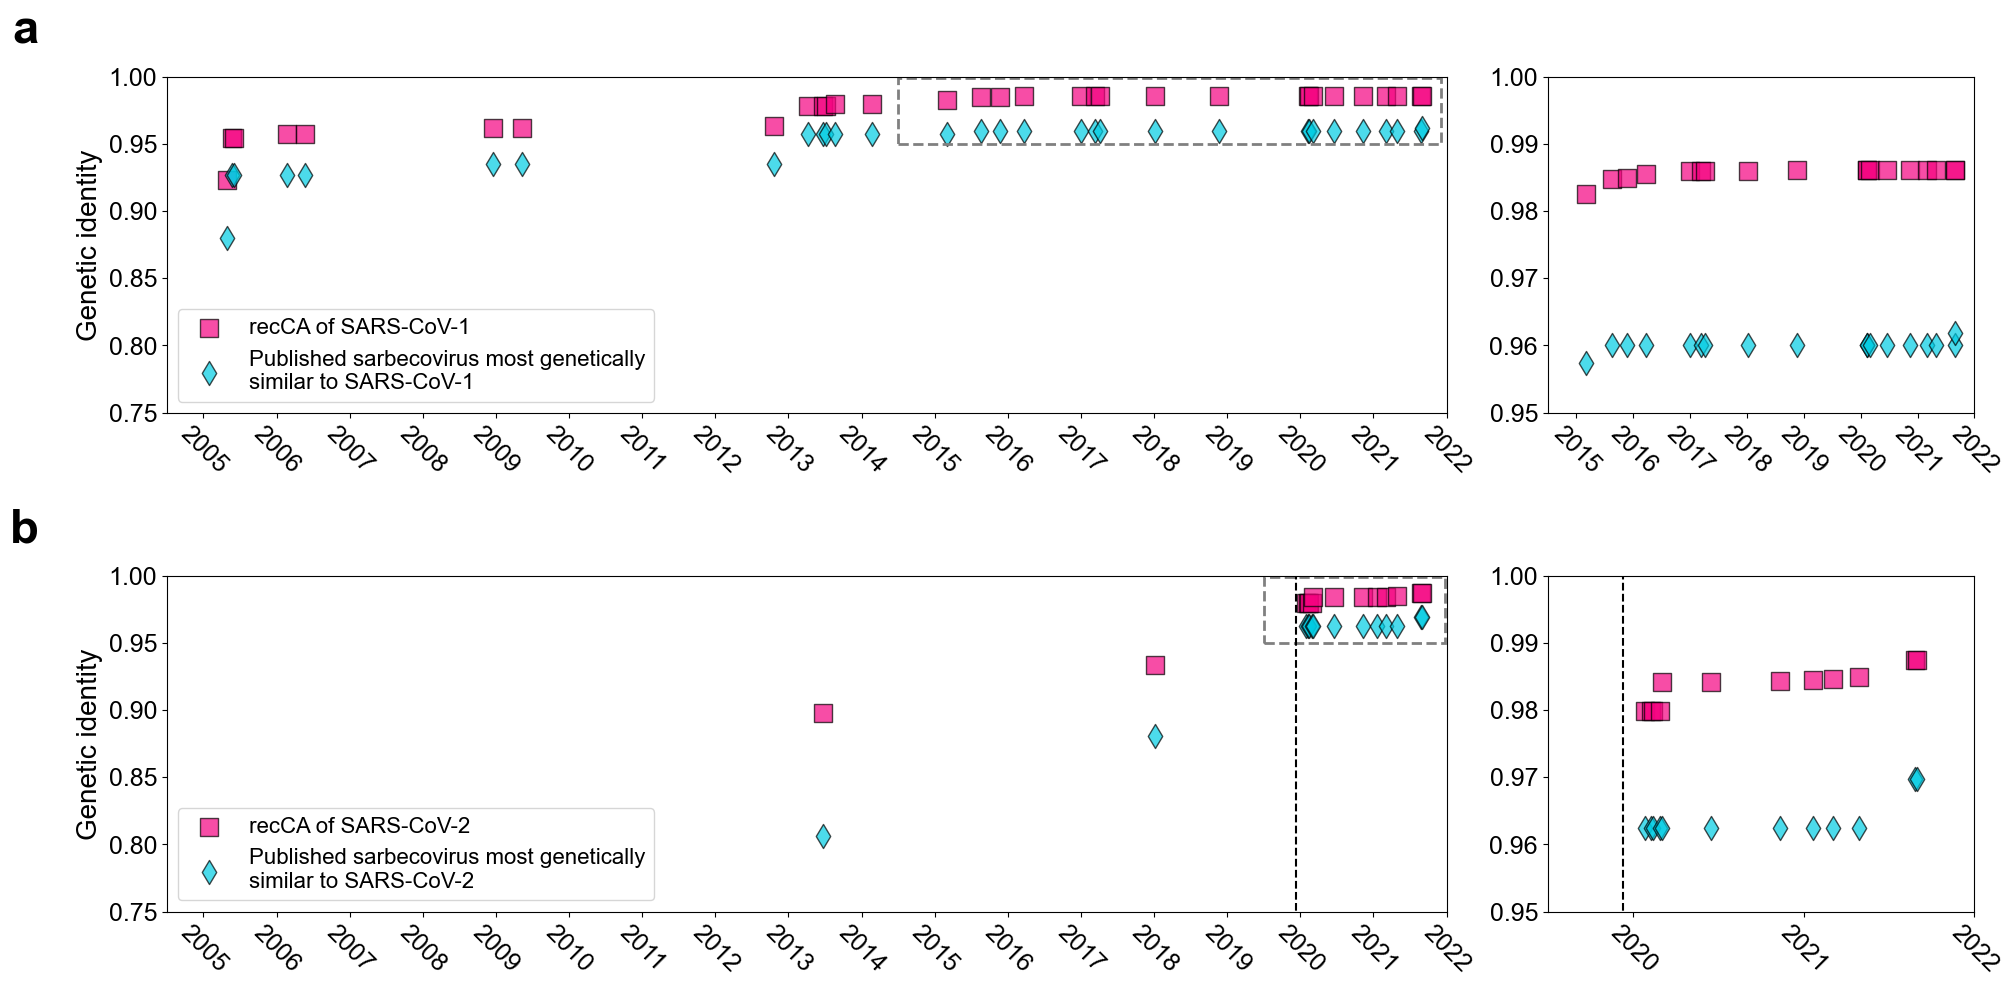

In [4]:
f, axes = plt.subplots(2,2,figsize=(20,10),facecolor='w',gridspec_kw={'width_ratios': [3, 1]})
axes = axes.flatten()

#########################################################################################################################################################################
################################################################################ sc1 ####################################################################################
#########################################################################################################################################################################

sc = 1
recCA_over_time_diffs = sc1_results['recCA_over_time_diffs']
sc_similarity_by_date = sc1_results['sc_similarity_by_date']
recCA_distance = sc1_results['recCA_distance']
recCA_similarity = sc1_results['recCA_similarity']
if sc == 1:
    first_sc_case_date = toYearFraction('2002-11-16')
    narrow_ylim = [2014.5,2022]
    narrow_xticks = np.linspace(2015,2022,8)
else:
    first_sc_case_date = toYearFraction('2019-12-10')
    narrow_ylim = [2019.5,2022]
    narrow_xticks = np.linspace(2020,2022,3)

wide_ylim = [2004.5,2022]
x = [float(x) for x in recCA_over_time_diffs.keys()]
y_recCA = recCA_over_time_diffs.values()
y_taxon = list(sc_similarity_by_date.values())
axes[0].scatter(x, y_recCA, marker='s', s=150, c='#f50280', edgecolors='black', label='recCA of SARS-CoV-1', alpha=0.7)
axes[0].scatter(x, y_taxon, marker='d', s=150, c='#00cce3', edgecolors='black', label='Published sarbecovirus most genetically\nsimilar to SARS-CoV-1', alpha=0.7)
axes[0].tick_params(axis='both', which='major', labelsize=18)
axes[0].set_xlim(wide_ylim)
axes[0].set_xticks(ticks=np.linspace(2005,2022,18))
axes[0].set_ylim([0.75, 1.0])

axes[1].scatter(x, y_recCA, marker='s', s=150, c='#f50280', edgecolors='black', label='recCA', alpha=0.7)
axes[1].scatter(x, y_taxon, marker='d', s=150, c='#00cce3', edgecolors='black', label='most similar sampled sarbecovirus', alpha=0.7)
axes[1].tick_params(axis='both', which='major', labelsize=18)
axes[1].set_xlim(narrow_ylim)
axes[1].set_xticks(ticks=narrow_xticks)
axes[1].set_ylim([0.95, 1.0])

# add date of emergence
axes[0].vlines(first_sc_case_date, 0, 1, linestyle='--', color='black')
axes[1].vlines(first_sc_case_date, 0, 1, linestyle='--', color='black')

# Create a Rectangle patch
rect = patches.Rectangle((narrow_ylim[0], 0.95), (narrow_ylim[1]-narrow_ylim[0])*.99, .05*.98, linewidth=2, edgecolor='grey', linestyle='--', facecolor='none')

# Add the patch to the Axes
axes[0].add_patch(rect)

plt.setp(axes[0].get_xticklabels(), ha="center", rotation=-45)
plt.setp(axes[1].get_xticklabels(), ha="center", rotation=-45)

axes[0].legend(loc='lower left', fontsize=16)
axes[0].set_ylabel('Genetic identity', fontsize=20)

#########################################################################################################################################################################
################################################################################ sc2 ####################################################################################
#########################################################################################################################################################################

sc = 2
recCA_over_time_diffs = sc2_results['recCA_over_time_diffs']
sc_similarity_by_date = sc2_results['sc_similarity_by_date']
recCA_distance = sc2_results['recCA_distance']
recCA_similarity = sc2_results['recCA_similarity']
if sc == 1:
    first_sc_case_date = toYearFraction('2002-11-16')
    narrow_ylim = [2014.5,2022]
    narrow_xticks = np.linspace(2015,2022,8)
else:
    first_sc_case_date = toYearFraction('2019-12-10')
    narrow_ylim = [2019.5,2022]
    narrow_xticks = np.linspace(2020,2022,3)

wide_ylim = [2004.5,2022]
x = [float(x) for x in recCA_over_time_diffs.keys()]
y_recCA = recCA_over_time_diffs.values()
y_taxon = list(sc_similarity_by_date.values())
axes[2].scatter(x, y_recCA, marker='s', s=150, c='#f50280', edgecolors='black', label='recCA of SARS-CoV-2', alpha=0.7)
axes[2].scatter(x, y_taxon, marker='d', s=150, c='#00cce3', edgecolors='black', label='Published sarbecovirus most genetically\nsimilar to SARS-CoV-2', alpha=0.7)
axes[2].tick_params(axis='both', which='major', labelsize=18)
axes[2].set_xlim(wide_ylim)
axes[2].set_xticks(ticks=np.linspace(2005,2022,18))
axes[2].set_ylim([0.75, 1.0])

axes[3].scatter(x, y_recCA, marker='s', s=150, c='#f50280', edgecolors='black', label='recCA', alpha=0.7)
axes[3].scatter(x, y_taxon, marker='d', s=150, c='#00cce3', edgecolors='black', label='most similar sampled sarbecovirus', alpha=0.7)
axes[3].tick_params(axis='both', which='major', labelsize=18)
axes[3].set_xlim(narrow_ylim)
axes[3].set_xticks(ticks=narrow_xticks)
axes[3].set_ylim([0.95, 1.0])

# add date of emergence
axes[2].vlines(first_sc_case_date, 0, 1, linestyle='--', color='black')
axes[3].vlines(first_sc_case_date, 0, 1, linestyle='--', color='black')

# Create a Rectangle patch
rect = patches.Rectangle((narrow_ylim[0], 0.95), (narrow_ylim[1]-narrow_ylim[0])*.99, .05*.98, linewidth=2, edgecolor='grey', linestyle='--', facecolor='none')

# Add the patch to the Axes
axes[2].add_patch(rect)

plt.setp(axes[2].get_xticklabels(), ha="center", rotation=-45)
plt.setp(axes[3].get_xticklabels(), ha="center", rotation=-45)

axes[2].legend(loc='lower left', fontsize=16)
axes[2].set_ylabel('Genetic identity', fontsize=20)


#### final adjustments
# add panel labels
axes[0].text(-0.1, 1.2, 'a', transform=axes[0].transAxes, fontsize=34, va='top', ha='right', fontweight='bold')
axes[2].text(-0.1, 1.2, 'b', transform=axes[2].transAxes, fontsize=34, va='top', ha='right', fontweight='bold')

plt.tight_layout(h_pad=2)
plt.show()
